In [1]:
import importlib
from pathlib import Path

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import utils

# Reload my external python modules
importlib.reload(utils)

<module 'utils' from '/home/thomas/Projects/ai-project-23-24/ThomasVanDaele/utils.py'>

In [2]:
# Read data
# Force reading columns as str to not losing leading zeros on (hexadecimal) ids
# Parse correct columns as datatime objects
data_dir = Path("data/")

articles = pd.read_csv(data_dir / 'articles.csv', dtype={'article_id': str, 'product_code': str})
customers = pd.read_csv(data_dir / 'customers.csv', dtype={'customer_id': str, 'postal_code': str})
sample_submission = pd.read_csv(data_dir / 'sample_submission.csv', dtype={'customer_id': str, 'prediction': str})
transactions_train = pd.read_csv(data_dir / 'transactions_train.csv', dtype={'customer_id': str, 'article_id': str}, parse_dates=['t_dat'])

In [3]:
articles.info()
customers.info()
transactions_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  object
 1   product_code                  105542 non-null  object
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

# EDA of customers

In [4]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [5]:
customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


In [6]:
utils.check_regex(customers, "customer_id", "^[a-f0-9]{64}$", unique=True)
customer_id_length = customers[customers['customer_id'].astype(str).map(len) == len(customers['customer_id'][0])]
print(f"Customer_id has same length in all rows: {customer_id_length.shape[0] == customers.shape[0]}")
utils.check_regex(customers, "postal_code", "^[a-f0-9]{64}$", unique=True)
postal_code_length = customers[customers['postal_code'].astype(str).map(len) == len(customers['postal_code'][0])]
print(f"Postal_code has same length in all rows: {postal_code_length.shape[0] == customers.shape[0]}")
print(customers["postal_code"].value_counts())

Rows not matching the regex:
Empty DataFrame
Columns: [customer_id, FN, Active, club_member_status, fashion_news_frequency, age, postal_code]
Index: []
All values for column customer_id are unique
Customer_id has same length in all rows: True
Rows not matching the regex:
Empty DataFrame
Columns: [customer_id, FN, Active, club_member_status, fashion_news_frequency, age, postal_code]
Index: []
Column postal_code has non unique values
Postal_code has same length in all rows: True
postal_code
2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    120303
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8       261
714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1       159
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7       157
5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145       156
                                                                     ...  
23bcd86dc11e0a0dc7f6cd7c90c67628824067566824b4d32e32247f

In [7]:
utils.print_na(customers, "customers", "age")
customers["age"].describe()

Total number of customers is 1371980. 1.1560664149623172% have no age.


count    1.356119e+06
mean     3.638696e+01
std      1.431363e+01
min      1.600000e+01
25%      2.400000e+01
50%      3.200000e+01
75%      4.900000e+01
max      9.900000e+01
Name: age, dtype: float64

<Axes: xlabel='age', ylabel='Count'>

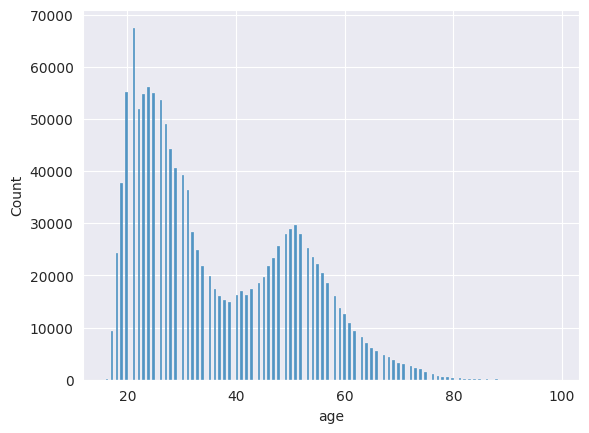

In [8]:
sns.histplot(customers["age"])

In [9]:
utils.print_na(customers, "customers", "FN")
customers["FN"].describe()

Total number of customers is 1371980. 65.23783145526903% have no FN.


count    476930.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: FN, dtype: float64

In [10]:
utils.print_na(customers, "customers", "Active")
customers["Active"].describe()

Total number of customers is 1371980. 66.15081852505138% have no Active.


count    464404.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: Active, dtype: float64

In [11]:
utils.print_na(customers, "customers", "club_member_status")
customers["club_member_status"].value_counts()

Total number of customers is 1371980. 0.44184317555649494% have no club_member_status.


club_member_status
ACTIVE        1272491
PRE-CREATE      92960
LEFT CLUB         467
Name: count, dtype: int64

In [12]:
utils.print_na(customers, "customers", "fashion_news_frequency")
customers["fashion_news_frequency"].value_counts()

Total number of customers is 1371980. 1.1669995189434248% have no fashion_news_frequency.


fashion_news_frequency
NONE         877711
Regularly    477416
Monthly         842
Name: count, dtype: int64

# Articles

In [13]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,0108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,0108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,0108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,0110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,0110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [14]:
articles.describe()

,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,105542.000000,1.055420e+05,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000
mean,234.861875,1.009515e+06,32.233822,3.206183,7.807972,4532.777833,3.171534,42.664219,1010.438290
std,75.049308,2.241359e+04,28.086154,1.563839,5.376727,2712.692011,4.353234,23.260105,6.731023
min,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,1201.000000,1.000000,2.000000,1001.000000
25%,252.000000,1.010008e+06,9.000000,2.000000,4.000000,1676.000000,1.000000,20.000000,1005.000000
50%,259.000000,1.010016e+06,14.000000,4.000000,5.000000,4222.000000,2.000000,46.000000,1009.000000
75%,272.000000,1.010016e+06,52.000000,4.000000,11.000000,7389.000000,4.000000,61.000000,1017.000000
max,762.000000,1.010029e+06,93.000000,7.000000,20.000000,9989.000000,26.000000,97.000000,1025.000000


In [15]:
articles.isna().sum() / articles.shape[0] * 100

article_id                      0.000000
product_code                    0.000000
prod_name                       0.000000
product_type_no                 0.000000
product_type_name               0.000000
product_group_name              0.000000
graphical_appearance_no         0.000000
graphical_appearance_name       0.000000
colour_group_code               0.000000
colour_group_name               0.000000
perceived_colour_value_id       0.000000
perceived_colour_value_name     0.000000
perceived_colour_master_id      0.000000
perceived_colour_master_name    0.000000
department_no                   0.000000
department_name                 0.000000
index_code                      0.000000
index_name                      0.000000
index_group_no                  0.000000
index_group_name                0.000000
section_no                      0.000000
section_name                    0.000000
garment_group_no                0.000000
garment_group_name              0.000000
detail_desc     

In [16]:
utils.check_regex(articles, "article_id", "^[0-9]{10}$", unique=True)
article_id_length = articles[articles['article_id'].astype(str).map(len) == len(articles['article_id'][0])]
print(f"Article_id has same length in all rows: {article_id_length.shape[0] == articles.shape[0]}")

Rows not matching the regex:
Empty DataFrame
Columns: [article_id, product_code, prod_name, product_type_no, product_type_name, product_group_name, graphical_appearance_no, graphical_appearance_name, colour_group_code, colour_group_name, perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name, department_no, department_name, index_code, index_name, index_group_no, index_group_name, section_no, section_name, garment_group_no, garment_group_name, detail_desc]
Index: []

[0 rows x 25 columns]
All values for column article_id are unique
Article_id has same length in all rows: True


In [17]:
utils.check_regex(articles, "product_code", "^[0-9]{7}$", unique=True)
product_code_length = articles[articles['product_code'].astype(str).map(len) == len(articles['product_code'][0])]
print(f"Product_code has same length in all rows: {product_code_length.shape[0] == articles.shape[0]}")

Rows not matching the regex:
Empty DataFrame
Columns: [article_id, product_code, prod_name, product_type_no, product_type_name, product_group_name, graphical_appearance_no, graphical_appearance_name, colour_group_code, colour_group_name, perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name, department_no, department_name, index_code, index_name, index_group_no, index_group_name, section_no, section_name, garment_group_no, garment_group_name, detail_desc]
Index: []

[0 rows x 25 columns]
Column product_code has non unique values
Product_code has same length in all rows: True


In [18]:
print_all = False
utils.inconsistency(articles, 'product_code', 'prod_name', print_all)
utils.inconsistency(articles, 'product_type_no', 'product_type_name', print_all)
utils.inconsistency(articles, 'graphical_appearance_no', 'graphical_appearance_name', print_all)
utils.inconsistency(articles, 'colour_group_code', 'colour_group_name', print_all)
utils.inconsistency(articles, 'perceived_colour_value_id', 'perceived_colour_value_name', print_all)
utils.inconsistency(articles, 'perceived_colour_master_id', 'perceived_colour_master_name', print_all)
utils.inconsistency(articles, 'department_no', 'department_name', print_all)
utils.inconsistency(articles, 'index_code', 'index_name', print_all)
utils.inconsistency(articles, 'index_group_no', 'index_group_name', print_all)
utils.inconsistency(articles, 'section_no', 'section_name', print_all)
utils.inconsistency(articles, 'garment_group_no', 'garment_group_name', print_all)

utils.inconsistency(articles, 'product_type_no', 'product_group_name', print_all)
utils.inconsistency(articles, 'index_code', 'index_group_no', print_all)

Found 2176 inconsistencies from product_code to prod_name
Found 3072 inconsistencies from prod_name to product_code
No inconsistencies from product_type_no to product_type_name
Found 1 inconsistencies from product_type_name to product_type_no
No inconsistencies from graphical_appearance_no to graphical_appearance_name
No inconsistencies from graphical_appearance_name to graphical_appearance_no
No inconsistencies from colour_group_code to colour_group_name
No inconsistencies from colour_group_name to colour_group_code
No inconsistencies from perceived_colour_value_id to perceived_colour_value_name
No inconsistencies from perceived_colour_value_name to perceived_colour_value_id
No inconsistencies from perceived_colour_master_id to perceived_colour_master_name
No inconsistencies from perceived_colour_master_name to perceived_colour_master_id
No inconsistencies from department_no to department_name
Found 22 inconsistencies from department_name to department_no
No inconsistencies from index

# Transaction data

In [19]:
transactions_train.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


In [20]:
transactions_train.describe()

,t_dat,price,sales_channel_id
count,31788324,3.178832e+07,3.178832e+07
mean,2019-09-15 17:27:46.894452992,2.782927e-02,1.704028e+00
min,2018-09-20 00:00:00,1.694915e-05,1.000000e+00
25%,2019-03-28 00:00:00,1.581356e-02,1.000000e+00
50%,2019-08-25 00:00:00,2.540678e-02,2.000000e+00
75%,2020-03-29 00:00:00,3.388136e-02,2.000000e+00
max,2020-09-22 00:00:00,5.915254e-01,2.000000e+00
std,NaN,1.918113e-02,4.564786e-01


In [21]:
transactions_train.isna().sum() / transactions_train.shape[0] * 100

t_dat               0.0
customer_id         0.0
article_id          0.0
price               0.0
sales_channel_id    0.0
dtype: float64

In [22]:
transactions_train["price"].describe()

count    3.178832e+07
mean     2.782927e-02
std      1.918113e-02
min      1.694915e-05
25%      1.581356e-02
50%      2.540678e-02
75%      3.388136e-02
max      5.915254e-01
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Count'>

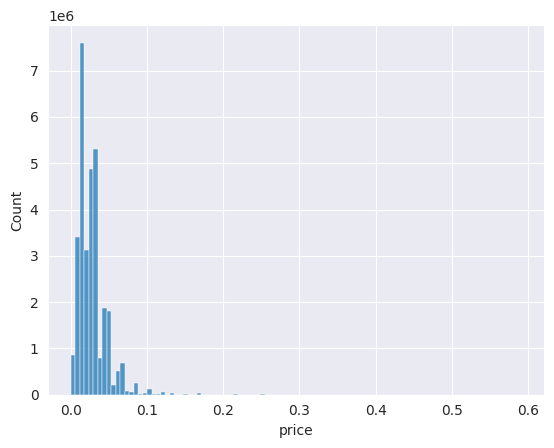

In [23]:
sns.histplot(transactions_train["price"], bins=100)

In [24]:
transactions_train["sales_channel_id"].value_counts()

sales_channel_id
2    22379862
1     9408462
Name: count, dtype: int64

In [25]:
utils.AinB(customers, "customer_id", transactions_train, "customer_id")

                                               customer_id   FN  Active  \
131      00058ecf091cea1bba9d800cabac6ed1ae284202cdab68...  NaN     NaN   
297      000df4d2084d142416b8165bdd249bab8fea2393447aed...  1.0     1.0   
544      00193ff7f374dbcfecfa7fead0488e454be4918bec1ebd...  NaN     NaN   
671      001f00e8c1eba437ff0dbad26a9a3d49e47cbf05fff02a...  1.0     1.0   
809      002648d8f3b288531b24860f4a68a31d029ec5a0495c04...  1.0     1.0   
...                                                    ...  ...     ...   
1371440  ffe5801cb2a5b51d4d068322d7f8082e995f427a6f22a6...  NaN     NaN   
1371554  ffeb3ca867aba57a312fe9d28d67dd46ef2240fe92a94c...  1.0     1.0   
1371739  fff456fa60aac9174456c2f36ede5e0f25429a16c88a34...  NaN     NaN   
1371872  fffa8d3cea26d4f5186472b923629b35fa28051f258030...  1.0     1.0   
1371961  ffff01710b4f0d558ff62d7dc00f0641065b37e840bb43...  1.0     1.0   

        club_member_status fashion_news_frequency   age  \
131                 ACTIVE              

In [26]:
utils.AinB(articles, "article_id", transactions_train, "article_id")

        article_id product_code                 prod_name  product_type_no  \
159     0187949032      0187949             Padded pyjama              295   
718     0288859020      0288859    Kakan 2-p cableknit BG              304   
2106    0395730045      0395730        VIOLA 2-pack (TVP)              257   
2708    0423900056      0423900  Gullan 5-p ankle sock SG              302   
3682    0462435036      0462435           6P Tanktop Body              256   
...            ...          ...                       ...              ...   
105529  0949323002      0949323       Flintstone cardigan              245   
105533  0950449002      0950449       Compact brush Fancy               78   
105535  0952937003      0952937                Jets dress              265   
105540  0957375001      0957375          CLAIRE HAIR CLAW               72   
105541  0959461001      0959461              Lounge dress              265   

               product_type_name  product_group_name  graphical

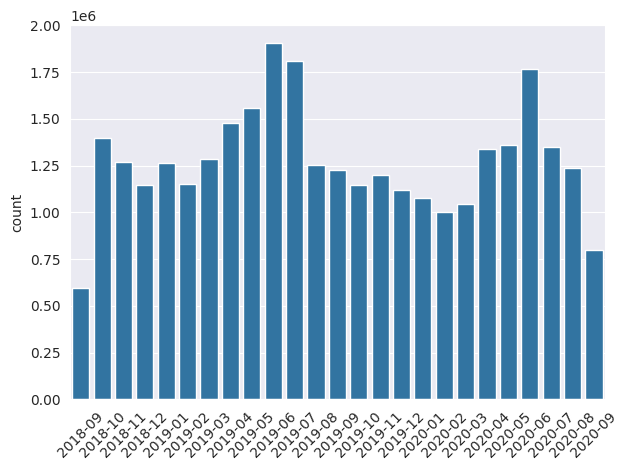

In [27]:
ax = sns.countplot(x=transactions_train.sort_values("t_dat")["t_dat"].dt.strftime('%Y-%m'))
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
plt.tight_layout()
plt.show()

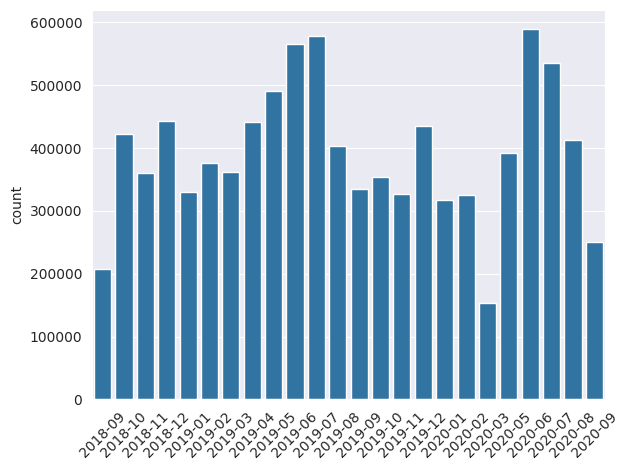

In [28]:
transaction_online = transactions_train[transactions_train["sales_channel_id"] == 1]
ax = sns.countplot(x=transaction_online.sort_values("t_dat")["t_dat"].dt.strftime('%Y-%m'))
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
plt.tight_layout()
plt.show()

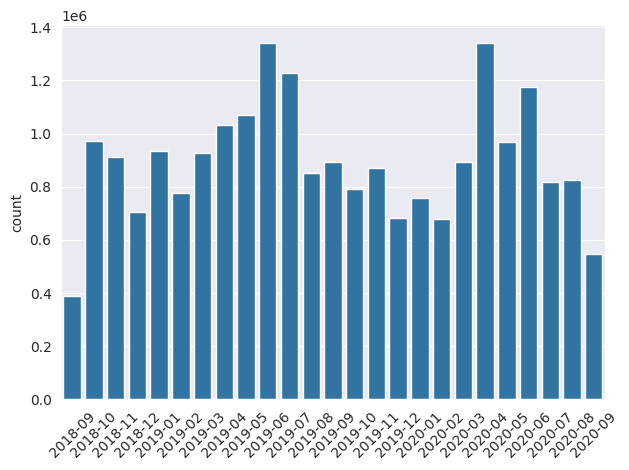

In [29]:
transaction_store = transactions_train[transactions_train["sales_channel_id"] == 2]
ax = sns.countplot(x=transaction_store.sort_values("t_dat")["t_dat"].dt.strftime('%Y-%m'))
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
plt.tight_layout()
plt.show()

In [30]:
utils.verify_submission(sample_submission, customers, articles)

No columns with nan values
Empty DataFrame
Columns: [customer_id, prediction, InDf2]
Index: []
Empty DataFrame
Columns: [customer_id, FN, Active, club_member_status, fashion_news_frequency, age, postal_code, InDf2]
Index: []
All are 12 items: True
['0108775015' '0108775044' '0108775051' ... '0956217002' '0957375001'
 '0959461001']
